In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import time as time
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Function Definitions

In [4]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    q_hats = []
    times = []
    errors = []
    upper_bounds = []
    lower_bounds = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            errors.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, errors, upper_bounds, lower_bounds

In [5]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    coverage = np.zeros(len(ci))
    upper_bounds = []
    lower_bounds = []
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, upper_bounds, lower_bounds

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

# Model Training

In [7]:
train = {1: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    3: {
    'start_time': "2011-04-19",
    'end_time': "2011-05-22"
},
    2: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    5: {
    'start_time': "2011-04-22",
    'end_time': "2011-06-01"
}}
test = {6: {
    'start_time': "2011-05-25",
    'end_time': "2011-06-13"
}}
appliances = ["Refrigerator"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [10]:
model = seq2point_gaussian.seq2point()

In [11]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

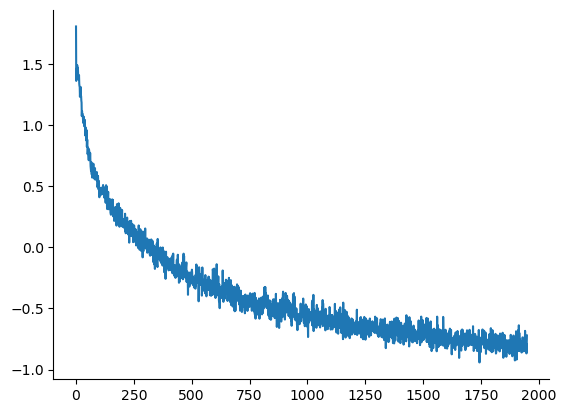

In [12]:
plt.plot(losses)
sns.despine()

In [13]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 15.1 s'

# Before Calibration

##### Results on Calibration Set

In [14]:
%%capture cap
%%time
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [15]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [16]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 37.2500 MAE  : 18.3295 NLL : 3.9151


In [17]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.49 s'

##### Results on Training Set

In [18]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [19]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [20]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 35.9441 MAE  : 17.3763 NLL : 3.8424


##### Results on Test Set

In [25]:
batch_size = 1024
sequence_length = 99

# Convolutional Layers
conv_flops = [
    30 * 10 * 10 * sequence_length * batch_size,
    30 * 8 * 8 * sequence_length * batch_size,
    40 * 6 * 6 * sequence_length * batch_size,
    50 * 5 * 5 * sequence_length * batch_size,
    50 * 5 * 5 * sequence_length * batch_size,
]

# Dense Layers
dense_flops = [
    1024 * sequence_length * 1024 * (sequence_length - 1),
    1024 * 21 * 1024 * (21 - 1),
]

# Total FLOPS
total_flops = sum(conv_flops) + sum(dense_flops)

print(
    f"FLOPS estimate for batch size {batch_size}: {total_flops / 1e9} GigaFLOPS")

FLOPS estimate for batch size 1024: 11.511877632 GigaFLOPS


In [30]:
%%capture cap
%%time
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})


In [22]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [23]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 45.9011 MAE  : 27.5620 NLL : 4.8781


In [24]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 1.57 s'

# After Calibration

### Conformal Prediction

##### Results on Calibration Set

In [123]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _, _, _, _ = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci)

In [124]:
initial_coverages_cal

array([0.        , 0.0716103 , 0.14546543, 0.21595332, 0.2856929 ,
       0.35902426, 0.4385663 , 0.52431905, 0.6432206 , 0.81465131,
       1.        ])

In [125]:
flag = True
final_coverages_cal, q_hats, times, errors, uppers_cal, lowers_cal = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci, flag=flag)

In [126]:
final_coverages_cal

array([0.        , 0.10011972, 0.2000898 , 0.30005988, 0.40010476,
       0.50014967, 0.60011977, 0.70016462, 0.80013472, 0.90017962,
       1.        ])

In [127]:
q_hats

[0,
 0.80122375,
 1.2566314,
 1.4263461,
 1.394434,
 1.319427,
 1.2173476,
 1.0845447,
 0.9173207,
 0.5123639,
 0]

In [128]:
errors

[array([ 4.8924866,  3.0611043,  4.1073995, ...,  8.47372  , 98.516106 ,
         2.8374228], dtype=float32),
 array([ 2.6516876,  2.4590392,  3.7812562, ...,  7.578439 , 92.653305 ,
         2.4610896], dtype=float32),
 array([ 0.33566284,  1.8367562 ,  3.444162  , ...,  6.6530967 ,
        86.59364   ,  2.0721192 ], dtype=float32),
 array([-2.1051025,  1.1809635,  3.0889153, ...,  5.6779246, 80.207664 ,
         1.6622024], dtype=float32),
 array([-4.7390594,  0.4732604,  2.7055488, ...,  4.625561 , 73.31619  ,
         1.2198386], dtype=float32),
 array([-7.6720886 , -0.31480074,  2.2786508 , ...,  3.4537044 ,
        65.64221   ,  0.72724485], dtype=float32),
 array([-11.090897  ,  -1.2333817 ,   1.7810502 , ...,   2.0877624 ,
         56.69725   ,   0.15306711], dtype=float32),
 array([-15.392548 ,  -2.3891673,   1.154954 , ...,   0.3690944,
         45.442444 ,  -0.5693803], dtype=float32),
 array([-21.768234  ,  -4.1022143 ,   0.22698593, ...,  -2.1782289 ,
         28.761139  ,

In [129]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)

In [130]:
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 1.0014965236186981 and ece error is 0.09104513851079074
Final ace error is 0.0011225640773772916 and ece error is 0.00010205127976157196


##### Results on Training Set

In [131]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _, _, _ = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.07542652, 0.14751072, 0.21989425, 0.29427317,
       0.3716951 , 0.45103762, 0.53686523, 0.65127707, 0.82624966,
       1.        ])

In [132]:
q_hats

[0,
 0.80122375,
 1.2566314,
 1.4263461,
 1.394434,
 1.319427,
 1.2173476,
 1.0845447,
 0.9173207,
 0.5123639,
 0]

In [133]:
flag = True
final_coverages_train, q_hats, uppers_train, lowers_train = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.10563204 0.20435499 0.31128404 0.41275066 0.51820815
 0.61837775 0.71540457 0.81614786 0.91155344 1.        ]


In [134]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)

In [135]:
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.9257706701755524 and ece error is 0.0841609700159593
Final ace error is 0.11371349543333051 and ece error is 0.010337590493939137


##### Results on Test Set

In [136]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _, _, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.05541982, 0.11232942, 0.17156309, 0.23365712,
       0.3035576 , 0.38144332, 0.46725464, 0.56176633, 0.70466602,
       1.        ])

In [137]:
q_hats

[0,
 0.80122375,
 1.2566314,
 1.4263461,
 1.394434,
 1.319427,
 1.2173476,
 1.0845447,
 0.9173207,
 0.5123639,
 0]

In [138]:
flag = True
final_coverages_test, q_hats, uppers_test, lowers_test = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.0677552  0.13169657 0.19665098 0.26869676 0.35176688
 0.44514632 0.55074191 0.66056854 0.75907278 1.        ]


In [39]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)

In [40]:
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 1.5083426348865032 and ece error is 0.13712205771695485
Final ace error is 1.0679040625691414 and ece error is 0.09708218750628558


##### Comparison of Results

In [42]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

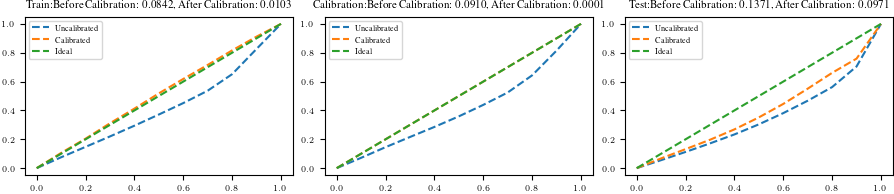

In [43]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')